This notebook: visualize epochs which are marked with artifacts.

- What kind of artifacts are actually annotated?
- What do eyeblink artifacts look like?
- How pervasive are they / other types?

In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/frank2015")

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m8krps8_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from mfn400.adapters.frank2015 import FrankDatasetAdapter

In [3]:
data = FrankDatasetAdapter(DATA_DIR, basedir / "output/frank2015/stim_df.csv")

In [4]:
epochs = data.to_epochs(EPOCH_WINDOW)

---

In [5]:
# Load reference ERP df, which includes artifact information
reference_df = pd.read_csv(basedir / "output/frank2015/erp/erp_full.csv",
                           index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  ...  \
subject_idx sentence_idx word_idx                                    ...   
1           1            0                3.145689         3.121044  ...   
                         1                8.214565         7.030273  ...   
                         2                8.330564         6.914139  ...   
                         3                3.210452         2.787990  ...   
                         4                8.541803         8.242652  ...   
...                                            ...              ...  ...   
24          205          7                3.924689         3.901125  ...   
                         8                7.945024         6.722867  ...   
                         9                9.959173         8.835783  ...   
                         10               3.884360         3.874658  ...   
                         11               8.574935         8.116138  ...   

                                   surp_rnn_size_6  surp_rnn_size_

In [90]:
# Merge into presentation data.
subject_idx = "1"
presentation_data = pd.merge(data.get_presentation_data(subject_idx),
                             reference_df[["artefact", "reject"]],
                             left_on=["subject_idx", "sentence_idx", "word_idx"],
                             right_index=True)

In [91]:
assert len(presentation_data) == len(epochs[subject_idx]), (len(presentation_data), len(epochs[subject_idx]))

In [92]:
presentation_data["epoch_idx"] = np.arange(len(presentation_data))

In [97]:
artifact_presentation = presentation_data[presentation_data.artefact == 1]

In [98]:
len(artifact_presentation) / len(presentation_data)

0.027446918694976695

In [99]:
artifact_presentation

,onset_time,word_idx,sentence_idx,subject_idx,presentation_idx,index,word,surprisal,word_len,word_freq,item,artefact,reject,epoch_idx
1,9.824,0,105,1,141,762,He,NaN,2,-5.139130,105,1,1,0
2,10.496,1,105,1,141,763,heaved,16.760948,6,-12.582876,105,1,1,1
129,139.692,8,190,1,115,1726,very,7.958524,4,-6.874683,190,1,1,117
218,241.304,8,172,1,61,1501,thirty,4.714210,6,-10.129065,172,1,1,196
244,268.960,8,135,1,91,1071,the,0.396672,3,-2.785981,135,1,1,220
245,269.644,9,135,1,91,1072,table,2.241891,5,-8.547702,135,1,1,221
316,362.212,0,191,1,56,1731,Brian,NaN,5,-10.094249,191,1,1,284
377,422.816,10,188,1,14,1704,soldier.,9.048402,8,-10.993445,188,1,1,341
507,628.740,8,195,1,59,1790,about,0.063778,5,-6.373984,195,1,1,456
508,629.468,9,195,1,59,1791,on,5.502264,2,-4.947598,195,1,1,457


## Artifact types

From manual browsing

In [102]:
def plot(idx):
    epochs[subject_idx][artifact_presentation.epoch_idx.iloc[idx]].plot()

### Data loss

Opening epochs-browser...


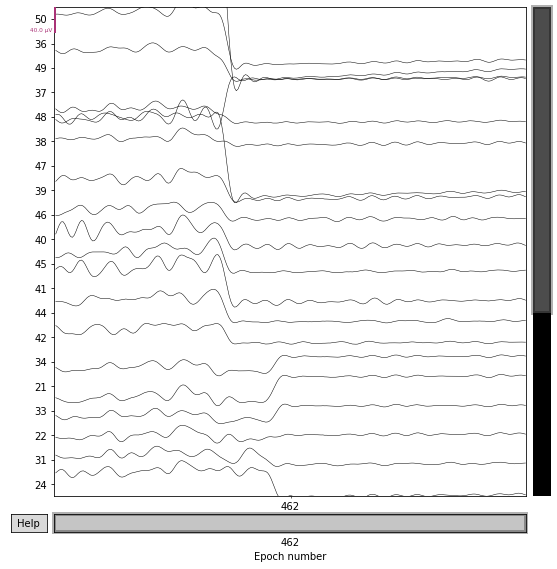

In [103]:
plot(10)

### Eyeblink

Opening epochs-browser...


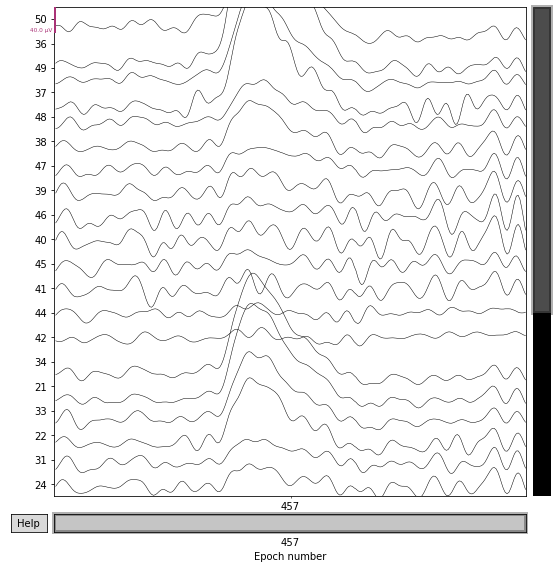

In [104]:
plot(9)

### ? LGTM

Opening epochs-browser...


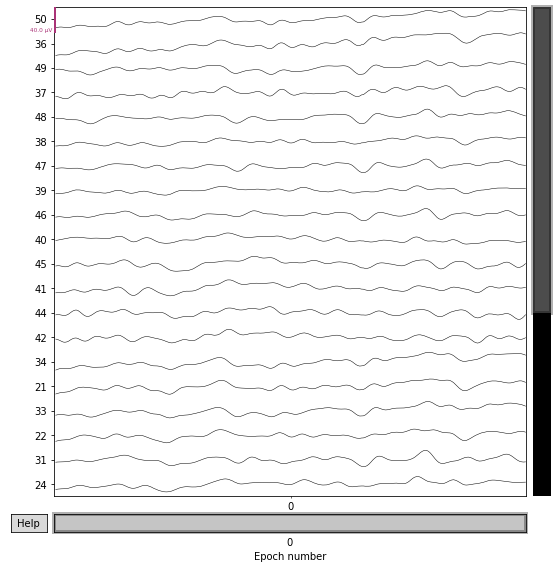

In [111]:
plot(0)